# Optical Flow for Odometry Estimation.

Our robots move in the real world! It is truly amazing!
As they move, it is important for them to know _how much_ they have moved. 

For example, if a robot has a map of a house, and it knows that the kitchen is 10 meters away from it in the forward direction, then it could navigate there only by moving forward and stopping after 10 meters. It is truly that simple! If the robot can measure its own motion that is. 

This type of motion is called **Ego-motion**, and the computation of the distance traversed is called **Odometry**. From the Greek words _Odos_ and _Metron_, which mean _route_ and _measure_.


The Odometry Estimation problem consists of two main steps; Finding **good patches** (feature extraction) to look for **correspondences** between sequential images and constructing the **optical flow field**.  As for the first, there are multiple approaches to solving this challenge, such as using the [Harris Corner Detector](https://medium.com/data-breach/introduction-to-harris-corner-detector-32a88850b3f6). Having these "good" patches ("matchable" points between frames) we can use various methods to construct the _optical flow field_ such as the **Lucas-Kanade method**. This tutorial will focus on the second step - _constructing the optical flow field_. 

What is optical flow? Suppose our camera moves with respect to the world, then a point in the world moves with respect to the camera. Consequently, the projection of the point in the image also changes. This movement in the image plane is called _Optical Flow_. 

Let's do some math!

**Note:** We solve the 2D SLAM problem, meaning our _z_ coordinate is constant.  

Having a point $(x, y)$ in the image plane which moves to $(x + \Delta x, y + \Delta y)$ in time $\Delta t$. Then we say that the optical flow components $(u, v)$ are as follows:
$$ u = \frac{\Delta x}{\Delta t}, v = \frac{\Delta y}{\Delta t} $$

One of the simplest approaches to find the optical flow is to assume that the flow is constant over local patch. Thus, we can use _Lucas Kanade_ tracker! However, we must first find patches to use! For simplicity, we assume that every patch in the image is a good patch, but no worries - we will publish an additional tutorial on the various methods that can be used. 

Okay, let's assume we have a good patch to track and define it as a $N \times N$ array of pixels located in the center of the image. 


### Lucas-Kanade (LK) method
---

Let's define a warp $W(\textbf{x})$ as an $SE(2)$ transformation such that
$$ W(\textbf{x}) = \textbf{R} \textbf{x} + \textbf{t} = \textbf{A} \tilde{\textbf{x}} $$ 
where $ \textbf{R} \in SO(2), \textbf{t} \in \mathbb{R}^2, \textbf{A} \in SE(2)$ and $\tilde{\textbf{x}} = \begin{bmatrix} \textbf{x} \\ 1 \end{bmatrix}$ is the homogeneous ccordinates of $\textbf{x} \in \mathbb{R}^2$. 


We want to find the warp between every two sequential image frames given to us by the system, to construct the odometry. 
Thus, our _LK_ algorithm should return a matrix $\textbf{A}_{i+1}^i  \in SE(2)$ when given a two sequential frames $I_i$ and $I_{i+1}$.

---
Let's formalize it. We look at the following "energy" function:

$$  E(\mathbf{p}) = \sum_{\mathbf{x} \in w}  [\Vert I_{i+1} (W(\mathbf{x} | \mathbf{p})) - I_{i}(\mathbf{x})\Vert]^2$$
Where $w$ is window and $\mathbf{p} \in \mathbb{R}^4$ is the vector which defines the transformation matrix:

$$ \mathbf{A} = \begin{bmatrix} 
1 + p_1 & -p_2 & p_3 \\
p_2 & 1 + p_1 & p_4 \\
0 & 0 & 1
\end{bmatrix}
$$

(We can also write $\mathbf{A} = \begin{bmatrix} 
1 + p_1 & -p_2 & p_3 \\
p_2 & 1 + p_1 & p_4
\end{bmatrix}$)

Denote that the rotation matrix is 
$\mathbf{R} = \begin{bmatrix} 1 + p_1 & -p_2 \\ p_2 & 1 + p_1 \end{bmatrix}$ 
and the translation vector is $ \mathbf{t} = \begin{bmatrix} p_3 \\ p_4 \end{bmatrix}$

Why did we defined the diagonal elements as $p_1 +1$? It's comfortable because when $p_1 = 0$ we get the identity matrix.

We want to find $\mathbf{p}$ such that $E$ is minimal. Thus, we need to solve a nonlinear least-square problem. We utilize [Gauss–Newton algorithm](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) (gradient based optimization method).

---
Starting with initial guess of $\mathbf{p} \ (\mathbf{p_0})$, we can look for the optimal $\mathbf{p}$ iteratively. At each iteration, the objective function (the "energy" function from above) is being locally linearized by first order taylor expension of $I_{i+1}(W(\mathbf{x}|\mathbf{p}))$:

$$ I_{i+1}(W(\mathbf{x}|\mathbf{p} + \Delta \mathbf{p}) \approx I_{i+1}(W(\mathbf{x}|\mathbf{p})) + \nabla I_{i+1}(W(\mathbf{x}|\mathbf{p})) \cdot \frac{\partial W}{\partial \mathbf{p}}\cdot \Delta \mathbf{p}$$

<!-- $$\Downarrow$$ -->

Where $\nabla I_{i+1}(W(\mathbf{x}|\mathbf{p}))$ is the gradient of the warped image, $\frac{\partial W}{\partial \mathbf{p}}$ is the jacobian of the warp and $\Delta \mathbf{p}$ is the parameter update.
$$\nabla I_{i+1}(W(\mathbf{x}|\mathbf{p})) =  \begin{bmatrix} \frac{\partial I_{i+1}(W(\mathbf{x}|\mathbf{p}))}{\partial x} & \frac{\partial I_{i+1}(W(\mathbf{x}|\mathbf{p}))}{\partial y} \end{bmatrix} $$ 

Recall that $ W(\mathbf{x}|\mathbf{p})) = \begin{bmatrix} 
1 + p_1 & -p_2 & p_3 \\
p_2 & 1 + p_1 & p_4
\end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$

Thus,
$$ \frac{\partial W}{\partial \mathbf{p}} = \begin{bmatrix} \frac{\partial W_{(x)}}{\partial p_1} & \frac{\partial W_{(x)}}{\partial p_2} & \frac{\partial W_{(x)}}{\partial p_3} & \frac{\partial W_{(x)}}{\partial p_4} \\
\frac{\partial W_{(y)}}{\partial p_1} & \frac{\partial W_{(y)}}{\partial p_2} & \frac{\partial W_{(y)}}{\partial p_3} & \frac{\partial W_{(y)}}{\partial p_4}
\end{bmatrix} = \begin{bmatrix} x & -y & 1 & 0 \\ y & x & 0 & 1
\end{bmatrix} $$

After plugging it in, we get that:

$$ \Delta \mathbf{p} = \sum_{\mathbf{x}} H^{-1} [\nabla I_{i+1} \frac{\partial W}{\partial \mathbf{p}}]^\top [I_i(\mathbf{x}) - I_{i+1}(W(\mathbf{x} | \mathbf{p}))]  $$
Where $H$ is the "approximated" hessian: $ H = \sum_{\mathbf{x}} [\nabla I_{i+1} \frac{\partial W}{\partial \mathbf{p}}]^\top [\nabla I_{i+1} \frac{\partial W}{\partial \mathbf{p}}] $

Sometime it's more conevnient to define the following notation:
$ \Delta \mathbf{p} = (\tilde{\textbf{A}}^\top \tilde{\textbf{A}})^{-1}\tilde{\textbf{A}}^\top \textbf{b} $

What are $\tilde{\textbf{A}}$ and $\textbf{b}$? Think about it and code it!!

---
 
#### **Let's start coding!!**

In [3]:
# If you don't have pne (or more) of the following packages installed, just uncomment them and run the cell!
# !pip install opencv-contrib-python
# !pip install numpy
# !pip install scipy

In [2]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import cv2
from matplotlib import pyplot as plt

In [40]:
def LucasKanade(It, It1, threshold, num_iters):
    """
    :param It: template image
    :param It1: Current image
    :param threshold: if the length of dp is smaller than the threshold, terminate the optimization
    :param num_iters: number of iterations of the optimization
    :return: M: the Affine warp matrix [2x3 numpy array] put your implementation here
    """

    ##############################
    # put your implementation here
    ##############################
    
    del_p = 10e3
    # Use RectBivariateSpline to define an object on which we can calculate spline interpolations including derivatives
    It1_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    It_spline = RectBivariateSpline(np.arange(It.shape[0]), np.arange(It.shape[1]), It)

    x, y = np.mgrid[:It.shape[1], :It.shape[0]]
    x, y = x.T, y.T
    p = np.array([0., 0., 0., 0.])
    iter_ = 0
    while np.linalg.norm(del_p) > threshold and iter_ <= num_iters:
        
        X, Y = (1 + p[0])*x - p[1]*y + p[2], p[1]*x + (1 + p[0])*y + p[3]

        valid = (X >= 0) & (X < It.shape[1]) & (Y >= 0) & (Y < It.shape[0])
        X, Y = X[valid], Y[valid]
        x_, y_ = x[valid], y[valid]
        It_int = It_spline.ev(y_, x_).flatten()

        It1_int = It1_spline.ev(p[1]*x_ + (1 + p[0])*y_ + p[3], (1 + p[0])*x_ - p[1]*y_ + p[2]).flatten()

        b = (It_int - It1_int).reshape(-1, 1)

        It1_dx = It1_spline.ev(Y, X, dy=1).flatten()
        It1_dy = It1_spline.ev(Y, X, dx=1).flatten()

        A = np.vstack((np.multiply(It1_dx, x_) + np.multiply(It1_dy, y_), 
                       - np.multiply(It1_dx, y_) + np.multiply(It1_dy, x_), 
                       It1_dx, 
                       It1_dy)).T

        del_p = np.linalg.inv(A.T @ A) @ (A.T @ b)
        p += del_p.flatten()
        iter_ += 1

    M = np.array([[1 + p[0], -p[1], p[2]], [p[1], 1 + p[0], p[3]]])
    return M

#### Usage Example:

In [41]:
data_path = "../../media/tmp/"
images = [cv2.cvtColor(cv2.imread(data_path + f"frame000{i}.jpg"), cv2.COLOR_BGR2GRAY).astype(np.float32)/255. for i in range(10)]

Example of two image: 
Images size: (600, 600)


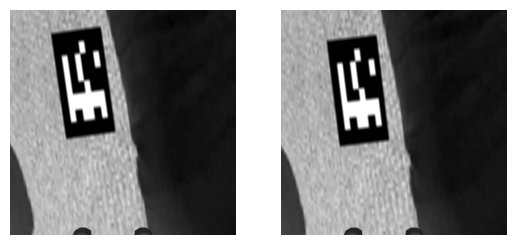

In [47]:
print("Example of two image: ")
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[8], cmap="gray");
ax[1].imshow(images[9], cmap="gray");
ax[0].axis("off"); ax[1].axis("off");
print(f"Images size: {images[0].shape}")

In [43]:
M = LucasKanade(images[8][100:-100,100:-100], images[9][100:-100,100:-100], 1e-2, 1e4)

In [44]:
M

array([[ 0.99906838, -0.02011976, 11.83144982],
       [ 0.02011976,  0.99906838, 19.06734407]])